In [1]:
import tensorflow as tf
from src.functions import initializers as ci  # i.e., custom initalizers
from src.functions.layers import ActivLin1D  # import the custom activation function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import data_handler as dh
from src.utils import plotter as pl
from train_forward_model import forward_training
from train_inverse_model import inverse_training

## Load forward training set

In [2]:
direct_dataset_path = '/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/csv/forward_profiles.csv'
# Load data
direct_dataset = dh.load_csv(direct_dataset_path)

In [3]:
# Check for NaNs
direct_dataset.isnull().values.any()

False

In [4]:
# Replacing infinite with NaN
direct_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
direct_dataset.dropna(inplace=True)

## Plot the dataset

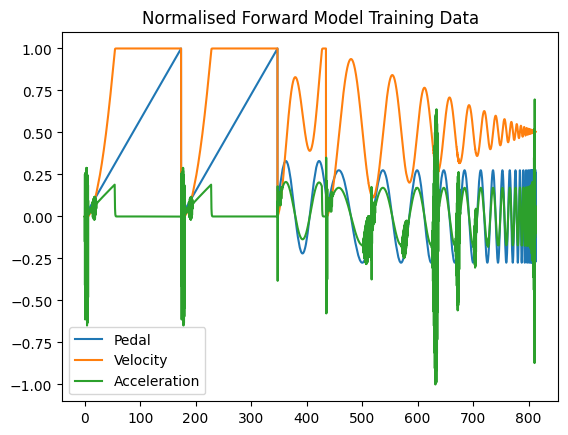

In [5]:
plt.plot(direct_dataset)
plt.title('Normalised Forward Model Training Data')
plt.legend(['Pedal' , 'Velocity' , 'Acceleration'])
plt.show()

## Train the forward model

In [ ]:
[forward_model,
     forward_history,
     forward_train_data,
     forward_valid_data,
     time,
     batch_size] = forward_training(direct_dataset)

Metal device set to: Apple M1


2023-02-08 13:35:28.813031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-08 13:35:28.813766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-08 13:35:28.821211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-08 13:35:28.824675: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-08 13:35:28.828803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 13:35:28.849816: I tensorflow/core/grappler/optimizers/custom_graph

Model: "custom_activation_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_vx (InputLayer)          [(100, 10)]          0           []                               
                                                                                                  
 tf_op_layer_strided_slice (Ten  [(100, 1)]          0           ['input_vx[0][0]']               
 sorFlowOpLayer)                                                                                  
                                                                                                  
 tf_op_layer_strided_slice_1 (T  [(100, 1)]          0           ['input_vx[0][0]']               
 ensorFlowOpLayer)                                                                                
                                                                            

## Plot the results

In [ ]:
pl.results(model=forward_model,
               history=forward_history,
               dataset=[forward_train_data,
                        forward_valid_data],
               time=time,
               batch_size=batch_size)

## Calculate input for the inverse model

In [ ]:
calculated_accelerations_1 = forward_model.predict(forward_train_data[0])
calculated_accelerations_2 = forward_model.predict(forward_valid_data[0])

calculated_accelerations = np.concatenate([calculated_accelerations_1 , calculated_accelerations_2])

In [ ]:
plt.plot(calculated_accelerations)

## Create input dataset for the inverse model

This data set should consist of the accelerations and the velocities

In [ ]:
time = pd.read_csv(direct_dataset_path , usecols=['time'])
velocity = pd.read_csv(direct_dataset_path , usecols=['velocity'])
acceleration = pd.DataFrame(calculated_accelerations , columns= ['acceleration'])
pedal = pd.DataFrame(calculated_accelerations , columns= ['pedal'])

In [ ]:
inverse_dataset = pd.concat([time , velocity, acceleration , pedal], axis=1)
inverse_dataset = inverse_dataset.set_index('time')

In [ ]:
# Replacing infinite with nan
inverse_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping all the rows with nan values
inverse_dataset.dropna(inplace=True)

In [ ]:
inverse_dataset

## Train the inverse model

In [ ]:
[inverse_model,
     inv_history,
     inv_train_data,
     inv_valid_data,
     time,
     batch_size] = inverse_training(inverse_dataset = inverse_dataset)

In [ ]:
pl.results(model=inverse_model,
               history=inv_history,
               dataset=[inv_train_data,
                        inv_valid_data],
               time=time,
               batch_size=batch_size)

In [ ]:
calculated_pedal_1 = inverse_model.predict(inv_train_data[0])
calculated_pedal_2 = inverse_model.predict(inv_valid_data[0])

calculated_pedal = np.concatenate([calculated_pedal_1 , calculated_pedal_2])

plt.plot(calculated_pedal)

# Test the inverse model to compare results to the C++ model

In [ ]:
acceleration = [0.059624,0.059353,0.059656,0.059939,0.060241,0.059911,0.059815,0.059599,0.059458,0.059668]
velocity = [0,0,0,0,-0.000006,-0.000054,-0.000407,-0.001846,0.000047,0.001719]

In [ ]:
velocity = np.array([velocity] , dtype='float32')
acceleration = np.array([acceleration] , dtype='float32')
input_data = [acceleration , velocity]


In [ ]:
prediction = inverse_model.predict( inv_train_data[0] )
prediction

In [ ]:
plt.plot(prediction)